# Validation and Model Selection

In [1]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn for plotting defaults
import seaborn as sns; sns.set()

## Validating Models

One of the most important pieces of machine learning is **model validation**: that is, checking how well your model fits a given dataset. But there are some pitfalls you need to watch out for.

Consider the digits example we've been looking at previously. How might we check how well our model fits the data?

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

Let's fit a K-neighbors classifier

In [3]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

Now we'll use this classifier to *predict* labels for the data

In [4]:
y_pred = knn.predict(X)

Finally, we can check how well our prediction did:

In [5]:
print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


It seems we have a perfect classifier!

**Question: what's wrong with this?**

## Validation Sets

Above we made the mistake of testing our data on the same set of data that was used for training. **This is not generally a good idea**. If we optimize our estimator this way, we will tend to **over-fit** the data: that is, we learn the noise.

A better way to test a model is to use a hold-out set which doesn't enter the training. We've seen this before using scikit-learn's train/test split utility:

In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

C:\Users\reshma\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


((1347L, 64L), (450L, 64L))

Now we train on the training data, and validate on the test data:

In [7]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

443 / 450 correct


This gives us a more reliable estimate of how our model is doing.

The metric we're using here, comparing the number of matches to the total number of samples, is known as the **accuracy score**, and can be computed using the following routine:

In [8]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.98444444444444446

This can also be computed directly from the ``model.score`` method:

In [9]:
knn.score(X_test, y_test)

0.98444444444444446

Using this, we can ask how this changes as we change the model parameters, in this case the number of neighbors:

In [10]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))

1 0.984444444444
5 0.986666666667
10 0.971111111111
20 0.964444444444
30 0.962222222222


We see that in this case, a small number of neighbors seems to be the best option.

## Cross-Validation

One problem with validation sets is that you "lose" some of the data. Above, we've only used 3/4 of the data for the training, and used 1/4 for the validation. Another option is to use **2-fold cross-validation**, where we split the sample in half and perform the validation twice:

In [11]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)
X1.shape, X2.shape

((898L, 64L), (899L, 64L))

In [12]:
print(KNeighborsClassifier(1).fit(X2, y2).score(X1, y1))
print(KNeighborsClassifier(1).fit(X1, y1).score(X2, y2))

0.983296213808
0.982202447164


Thus a two-fold cross-validation gives us two estimates of the score for that parameter.

Because this is a bit of a pain to do by hand, scikit-learn has a utility routine to help:

In [13]:
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=10)
cv.mean()

0.97614938602520218

### K-fold Cross-Validation

Here we've used 2-fold cross-validation. This is just one specialization of $K$-fold cross-validation, where we split the data into $K$ chunks and perform $K$ fits, where each chunk gets a turn as the validation set.
We can do this by changing the ``cv`` parameter above. Let's do 10-fold cross-validation:

In [14]:
cross_val_score(KNeighborsClassifier(1), X, y, cv=10)

array([ 0.93513514,  0.99453552,  0.97237569,  0.98888889,  0.96089385,
        0.98882682,  0.99441341,  0.98876404,  0.97175141,  0.96590909])

This gives us an even better idea of how well our model is doing.

## Overfitting, Underfitting and Model Selection

In [15]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Now let's create a realization of this dataset:

In [16]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

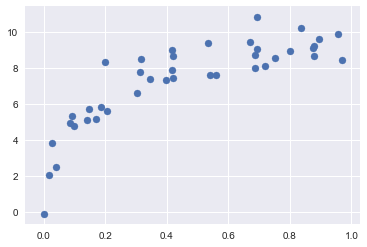

In [17]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

### Underfit

Now say we want to perform a regression on this data.  Let's use the built-in linear regression function to compute a fit:

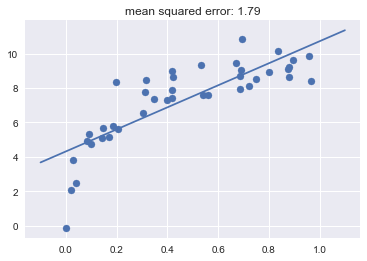

In [18]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

## Perfect fit

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

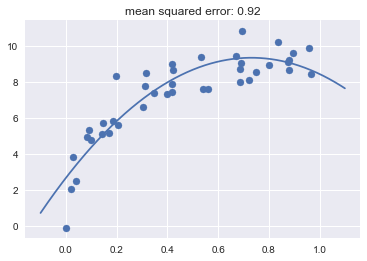

In [23]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

## Overfit

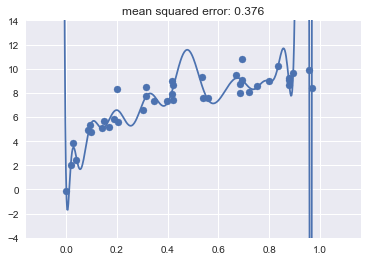

In [25]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14);